# 3D brain visualizations for ABA staNMF manuscript
Using Napari (https://napari.org/).

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import napari  # May require installing napari
import numpy as np
import pandas as pd
import pickle
from PIL import Image, ImageFilter
import scipy.ndimage
from scipy.ndimage import binary_dilation
from skimage.morphology import remove_small_holes, remove_small_objects, ball, cube, binary_closing
# from staNMF import staNMF

In [2]:
##################
# Load DecGene PPs
##################
tmp = np.load('../output/DecGene_final_11_PPs.npz', allow_pickle=True)
PPs_3d = tmp['PPs_3d']
PPs_3d.shape

(11, 66, 40, 57)

In [3]:
#################
# Load PCA PPs
#################
tmp = np.load('../output/PCA_final_11_PPs.npz', allow_pickle=True)
PCA_PPs_3d = tmp['PPs_3d']
PCA_PPs_3d.shape

(11, 66, 40, 57)

In [ ]:
# """ Create brain """
# # load reference atlas
# areas_atlas_detail = np.load('mouse_areas_structure_atlas.npy')

# # preprocess compute the support
# brain_p56 = np.sum(areas_atlas_detail, 0) > 0

# # convert to int
# brain_p56 = brain_p56.astype(int)

# # binarize
# brain_p56_binarized = remove_small_holes(brain_p56, area_threshold=2)
# brain_p56_binarized = binary_closing(brain_p56, footprint=ball(2)) ## Try binary_closing 

# # dilation
# brain_p56_dilation = binary_dilation(brain_p56_binarized, structure=ball(2))

# # subtract to get border
# brain_p56_done = np.subtract(brain_p56_dilation, brain_p56_binarized, dtype=np.float32)

# # # Create Napari viewer
# # viewer = napari.Viewer()

# # # Add full brain to viewer
# # NAME='brain p56'
# # viewer.add_image(brain_p56_done, name=NAME, colormap='green')
# # viewer.layers[NAME].rendering='average'

In [4]:
### Template Brain: using Alex's high-res file

# Load
template_brain = np.load('../data/template.npy')
print(template_brain.shape)

# Flip across axis to match orientatin of PPs
template_brain = np.flip(template_brain, axis=1)

# # Create Napari viewer
# viewer = napari.Viewer()

# # Add full brain to viewer
# NAME='template'
# viewer.add_image(template_brain, name=NAME, colormap='green')

(132, 80, 114)


In [5]:
""" This function creates a 3D visualization from input of PPs. """
""" This still requires some processing in Napari to look right. """
""" Input PPs (numpy array), name of target subject (string), and the organ name (string). """

def create_3D_visualization(_brain, _PPs1, _CCFregions):

    # Create Napari viewer
    viewer = napari.Viewer()

    # Add full brain to viewer
    NAME="3D Brain"
    viewer.add_image(_brain, name=NAME, colormap='green')
    viewer.layers[NAME].rendering='average' 
    viewer.layers[NAME].gamma=1   
    ## note: adjust contrast limit bar to have roughly 20% of the left side of bar area
    ## note: change 'interpolation' to 'nearest'

    # Add PPs1 to viewer
    i = 0
    for i in range(11):
        
        # Zoom PPs to nearly match template size
        _PP_zoom1 = scipy.ndimage.zoom(_PPs1[i], 2, order = 0)

        # Display PP
        NAME="PP: "+ str(i)
        viewer.add_image(_PP_zoom1, name=NAME, colormap='yellow')
        viewer.layers[NAME].opacity=1
        viewer.layers[NAME].gamma=1   # tried 0.5 and 1 for gamma. chose 1 as best visualization.
        viewer.layers[NAME].colormap='red'     # 'red' for DecGene; 'yellow' for PCA
        viewer.layers[NAME].blending='additive' 
        viewer.layers[NAME].depiction='volume'
        viewer.layers[NAME].rendering='additive' # note: change to attenuated MLP in viewer and keep slide bar 20% from left side
    
    # Add brain regions to viewer
    i = 0
    for i in range(12):

        # Zoom PPs to nearly match template size
        _CCF_zoom = scipy.ndimage.zoom(_CCFregions[i], 2, order = 0)

        # Add to viewer
        NAME='CCF Region' + ": "+ str(i)
        viewer.add_image(_CCF_zoom, name=NAME, colormap='cyan')
        viewer.layers[NAME].opacity=1
        viewer.layers[NAME].gamma=0.4        # changed gamma to 0.4 to improve contrast
        viewer.layers[NAME].colormap='cyan'
        viewer.layers[NAME].blending='additive'
        viewer.layers[NAME].depiction='volume'
        viewer.layers[NAME].rendering='average'  # note: keep rendering at average

In [6]:
# remove lowest nth percentile of array: DecGene
percentile_staNMF = 0.1   # decided on 0.1 for best visualization (tried 0.05, 0.15, 0.2)

tmp = np.load('../output/DecGene_final_11_PPs.npz', allow_pickle=True)
PPs_3d = tmp['PPs_3d']

zero_share = 1 - np.count_nonzero(PPs_3d > 0)/(11*66*40*57) # share of values that are already zero in array
percentile_input = zero_share + (1-zero_share)*percentile_staNMF # add extra percentile to existing values that are already zero 
percentile_index = np.percentile(PPs_3d, percentile_input*100) # estimate percentile index
print(percentile_input, zero_share, percentile_index) # check values


PPs_3d_cleaned = PPs_3d
PPs_3d_cleaned[PPs_3d_cleaned < percentile_index] = 0

tmp = np.load('../output/DecGene_final_11_PPs.npz', allow_pickle=True)
PPs_3d = tmp['PPs_3d']

np.sum(PPs_3d), np.sum(PPs_3d_cleaned)

0.9243970204436711 0.9159966893818569 0.05742091902935363


(15888.938306611031, 15142.913927435875)

In [7]:
# remove lowest nth percentile of array: PCA
percentile_PCA = percentile_staNMF     # match percentile for staNMF

tmp = np.load('../output/PCA_final_11_PPs.npz', allow_pickle=True)
PCA_PPs_3d = tmp['PPs_3d']
PCA_PPs_3d[PCA_PPs_3d == False] = 0

zero_share = 1 - np.count_nonzero(PCA_PPs_3d > 0)/(11*66*40*57)
percentile_input = zero_share + (1-zero_share)*percentile_PCA # add extra percentile to existing values that are already zero 
percentile_index = np.percentile(PCA_PPs_3d, percentile_input*100) # estimate percentile index
print(percentile_input, zero_share, percentile_index) # check values

PCA_PPs_3d_cleaned = PCA_PPs_3d
PCA_PPs_3d_cleaned[PCA_PPs_3d_cleaned < percentile_index] = 0

tmp = np.load('../output/PCA_final_11_PPs.npz', allow_pickle=True)
PCA_PPs_3d = tmp['PPs_3d']

np.sum(PCA_PPs_3d), np.sum(PCA_PPs_3d_cleaned)


0.8262994780339278 0.8069994200376975 0.0004701419604647978


(1088.0426080378595, 1080.8813641400193)

In [8]:
# #################################
# # Run for both DG ABA and PCA
# #################################

# # load atlas
# areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
# mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')

# # run function and open Napari viewer
# create_3D_visualization(_brain=template_brain,
#                         _PPs1=PPs_3d_cleaned,
#                         _PPs2=PCA_PPs_3d_cleaned,
#                         _CCFregions=areas_atlas,
#                         "Mouse Brain NMF PP",
#                         "Brain")

In [46]:
####################
# Run for DG ABA
####################

# Reload staNMF PPs
tmp = np.load('../output/DecGene_final_11_PPs.npz', allow_pickle=True)
PPs_3d = tmp['PPs_3d']
PPs_3d.shape

# binarize PPs
#PPs_3d = (PPs_3d > 0.1).astype(np.int_)
#PPs_3d = remove_small_holes(PPs_3d, area_threshold=2)

# load atlas
areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')

# run function
create_3D_visualization(_brain=template_brain,
                        _PPs1=PPs_3d_cleaned,
                        _CCFregions=areas_atlas)

In [9]:
#################
# Run for PCA ABA
#################

# Reload PCA PPs
tmp = np.load('../output/PCA_final_11_PPs.npz', allow_pickle=True)
PCA_PPs_3d = tmp['PPs_3d']
PCA_PPs_3d.shape

# binarize PPs
#PCA_PPs_3d = (PCA_PPs_3d > 0.005).astype(np.int_)
#PCA_PPs_3d = remove_small_holes(PCA_PPs_3d, area_threshold=2)

# load atlas
areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')

# run function
create_3D_visualization(_brain=template_brain,
                        _PPs1=PCA_PPs_3d_cleaned,
                        _CCFregions=areas_atlas)

Traceback (most recent call last):
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/napari/_qt/layer_controls/qt_image_controls_base.py", line 139, in changeColor
    self.layer.colormap = self.colormapComboBox.currentData()
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/napari/layers/intensity_mixin.py", line 61, in colormap
    self._update_thumbnail()
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/napari/layers/image/image.py", line 869, in _update_thumbnail
    downsampled = ndi.zoom(
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/scipy/ndimage/_interpolation.py", line 767, in zoom
    zoom = _ni_support._normalize_sequence(zoom, input.ndim)
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/scipy/ndimage/_ni_support.py", line 67, in _normalize_sequence
    raise RuntimeError(err)
RuntimeError: sequence argument must have length equal to input rank
Traceback (most recent call last):
  File

Traceback (most recent call last):
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/napari/_qt/layer_controls/qt_image_controls_base.py", line 139, in changeColor
    self.layer.colormap = self.colormapComboBox.currentData()
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/napari/layers/intensity_mixin.py", line 61, in colormap
    self._update_thumbnail()
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/napari/layers/image/image.py", line 869, in _update_thumbnail
    downsampled = ndi.zoom(
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/scipy/ndimage/_interpolation.py", line 767, in zoom
    zoom = _ni_support._normalize_sequence(zoom, input.ndim)
  File "/opt/anaconda3/envs/napari-env/lib/python3.9/site-packages/scipy/ndimage/_ni_support.py", line 67, in _normalize_sequence
    raise RuntimeError(err)
RuntimeError: sequence argument must have length equal to input rank
Traceback (most recent call last):
  File

### coronal projections for fig 2

In [9]:
#define_function a function that shows two genes together
def visualize_gene(geneA, template = 0, colorA = 'green', missing_mask = True): 
        
    geneA = np.maximum(geneA, 0)
    
    color_map = {'red':0, 'green':1, 'blue':2}
    colorA = color_map[colorA]    
    if missing_mask:
        geneA = geneA > 0

    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    
    x_dim, y_dim, z_dim = geneA.shape
    
    if np.sum(template) == 0:
        template = np.zeros((x_dim, y_dim, z_dim))
    
    out1 = np.zeros((y_dim, z_dim, 3))
    out1[:,:,colorA] = np.sum(geneA, 0)
    out1[:,:,colorA] /= np.max(out1[:,:,colorA])

    # to make yellow for PCA
    out1[:,:,1] = np.sum(geneA, 0)
    out1[:,:,1] /= np.max(out1[:,:,1])

    
    image = Image.fromarray(np.uint8(cm.gist_earth(np.sum(template,0))*255))
    image = image.filter(ImageFilter.MaxFilter(3))
    image = image.filter(ImageFilter.MinFilter(3))
    image = image.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,
                                          -1, -1, -1, -1), 1, 0))
    support_x = np.array(image.filter(ImageFilter.FIND_EDGES))[:,:,0]
    
    for rgb_ch in range(3):
        out1[:,:,rgb_ch] = out1[:,:,rgb_ch] + support_x
#         out1[:,:,1] = support_x
    c.imshow(out1)
    #plt.colorbar()
    
    out2 = np.zeros((x_dim, z_dim, 3))
    out2[:,:,colorA] = np.sum(geneA, 1)
    out2[:,:,colorA] /= np.max(out2[:,:,colorA])
    
    # to make yellow for PCA
    out2[:,:,1] = np.sum(geneA, 1)
    out2[:,:,1] /= np.max(out2[:,:,1])

    
    image = Image.fromarray(np.uint8(cm.gist_earth(np.sum(template,1))*255))
    image = image.filter(ImageFilter.MaxFilter(5))
    image = image.filter(ImageFilter.MinFilter(5))
    image = image.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,
                                          -1, -1, -1, -1), 1, 0))
    support_y = np.array(image.filter(ImageFilter.FIND_EDGES))[:,:,0]    

    for rgb_ch in range(3):
        out2[:,:,rgb_ch] = out2[:,:,rgb_ch] + support_y
#         out2[:,:,1] = support_y
    b.imshow(out2)
    #plt.colorbar()
    
    plt.figure()
    
    out3 = np.zeros((y_dim, x_dim, 3))
    out3[:,:,colorA] = np.sum(geneA, 2).T
    out3[:,:,colorA] /= np.max(out3[:,:,colorA])
    
    # to make yellow
    out3[:,:,1] = np.sum(geneA, 2).T
    out3[:,:,1] /= np.max(out3[:,:,1])

    
    image = Image.fromarray(np.uint8(cm.gist_earth(np.sum(template,2))*255))
    image = image.filter(ImageFilter.MaxFilter(3))
    image = image.filter(ImageFilter.MinFilter(3))
    image = image.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,
                                          -1, -1, -1, -1), 1, 0))
    support_z = np.array(image.filter(ImageFilter.FIND_EDGES))[:,:,0]   
    
    for rgb_ch in range(3):
        out3[:,:,rgb_ch] = out3[:,:,rgb_ch] + support_z.T
#         out3[:,:,1] = support_z.T
        
    a.imshow(out3)
    
#     a.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
#     b.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
#     c.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    b.axes.get_xaxis().set_visible(False)
    b.axes.get_yaxis().set_visible(False)
    c.axes.get_xaxis().set_visible(False)
    c.axes.get_yaxis().set_visible(False)
    
    plt.show()

In [10]:
# upload template
template = np.flip(np.load('../data/template.npy'),1)

In [11]:
# upsample PPs
_upsample=2
PPs_upsampled = PPs_3d
PPs_upsampled = np.repeat(PPs_upsampled,2,axis=1)
PPs_upsampled = np.repeat(PPs_upsampled,2,axis=2)
PPs_upsampled = np.repeat(PPs_upsampled,2,axis=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


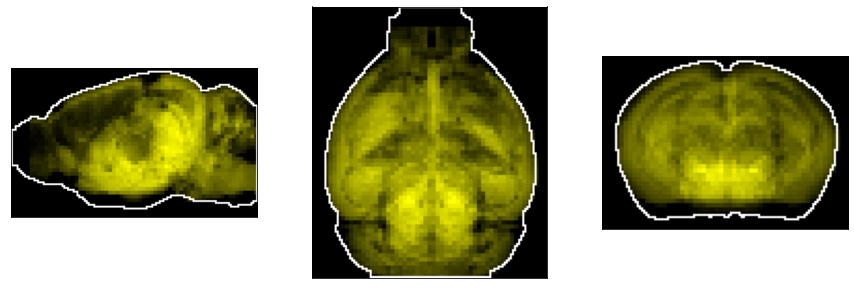

<Figure size 432x288 with 0 Axes>

In [12]:
# visualize with template
pp=10

# PP
visualize_gene(geneA=PPs_upsampled[pp], template = template, colorA = 'red')

In [13]:
# upsample PCA PPs
_upsample=2
PCA_PPs_upsampled = PCA_PPs_3d
PCA_PPs_upsampled = np.repeat(PCA_PPs_upsampled,2,axis=1)
PCA_PPs_upsampled = np.repeat(PCA_PPs_upsampled,2,axis=2)
PCA_PPs_upsampled = np.repeat(PCA_PPs_upsampled,2,axis=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


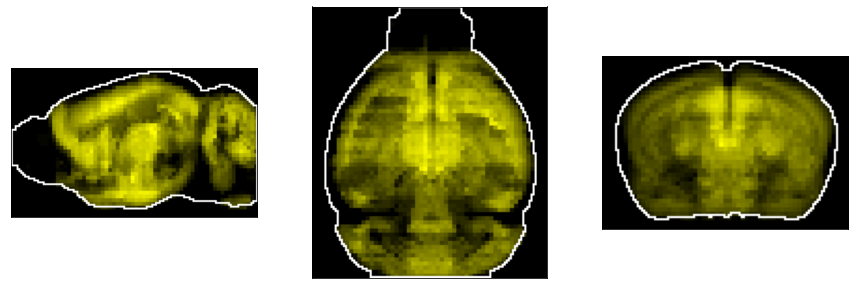

<Figure size 432x288 with 0 Axes>

In [14]:
# visualize with template
pp=10

# PP
visualize_gene(geneA=PCA_PPs_upsampled[pp], template = template, colorA = 'red')